<a href="https://colab.research.google.com/github/EliaFeltrin/KIND_project/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name Entity Recognition

In [1]:
def get_string_from_df(dataframe, puntuaction):
  '''
  Transforms the tokenized dataset into a single string.
  
  Parameters
  ----------
  dataframe: DataFrame
    structure containing the tokenized dataset

  Returns
  -------
  text: str
    string concatenating all the tokens of the dataset
  '''
  text_df = dataframe.loc[:,'Token']
  text = text_df[0]
  for token in text_df[1:]:
    text += (' ' + token) if token not in puntuaction else token
  return text

## Introduction

### Package Installation

In [ ]:
# Installing the library needed in the following part of the project

# Installing the utlity packages
#! pip install scipy
#! pip install numpy
#! pip install pandas

# Installing the packages for creating amazing plots
#! pip install matplotlib
#! pip install wordcloud
! pip install plotly
! pip install --upgrade nbformat

# Installing a package for sequence labeling, used for POS tagging and NER
! pip install -U spacy

# Installing the packages for creating the word embeddings
! pip install --upgrade gensim
! pip install fasttext

# Installing the packages for doing dimensionality reduction
#! pip install sklearn
! pip install umap-learn
! pip install python-terrier

In [ ]:
# Dowloading an italian model from spacy
! spacy download it_core_news_sm

### Package import

In [2]:
# Importing the main packages

# Importing the utlity packages
import string
import numpy as np
import random
import pandas as pd
from collections import Counter

# Importing the packages for creating amazing plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px


# Importing the packages for POS tagging
import spacy as spc

# Importing the packages for creating the word embeddings
from gensim.models.word2vec import Word2Vec
#import fasttext
#import fasttext.util

# Importing the packages for doing dimensionality reduction
from sklearn.manifold import TSNE
#import umap
import pyterrier as pt
if not pt.started():
  pt.init()

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



In [3]:
# Defining the names of the datasets
dataset_names = ['degasperi_train.tsv', 'degasperi_test.tsv', 'fiction_train.tsv',\
            'fiction_test.tsv', 'moro_train.tsv', 'moro_test.tsv',\
            'wikinews_train.tsv', 'wikinews_test.tsv']
# Defining the path to datasets
PATH_TO_DATASETS = '../datasets/Inside_outside_NER_notation'
# Enrico's path, scusate ragazzi, sistemerò TO DOOOOOOOOOOOOOOOOO
#PATH_TO_DATASETS = '/Users/enricosimionato/Desktop/KIND_project/datasets/Inside_outside_NER_notation'
# Importing all the datasets in a dictionary
datasets_dict = {name: pd.read_csv(PATH_TO_DATASETS+'/'+name, sep='[\t|\n]', names=['Token', 'Entity'], engine='python') for name in dataset_names}

In [4]:
# Defining the path to datasets
PATH_TO_DATASETS = '../datasets/Inside_outside_NER_notation'
# Enrico's path, scusate ragazzi, sistemerò TO DOOOOOOOOOOOOOOOOO
#PATH_TO_DATASETS = '/Users/enricosimionato/Desktop/KIND_project/datasets/Inside_outside_NER_notation'

# Loading the datasets
dataset_degasperi = pd.read_csv(PATH_TO_DATASETS+'/degasperi_train.tsv', sep='\t', header=None)
dataset_degasperi = dataset_degasperi.rename(columns={0: 'Token', 1: 'Entity'})

dataset_moro = pd.read_csv(PATH_TO_DATASETS+'/moro_train.tsv', sep='\t', header=None)
dataset_moro = dataset_moro.rename(columns={0: 'Token', 1: 'Entity'})

dataset_fiction = pd.read_csv(PATH_TO_DATASETS+'/fiction_train.tsv', sep='\t', header=None)
dataset_fiction = dataset_fiction.rename(columns={0: 'Token', 1: 'Entity'})

dataset_wikinews = pd.read_csv(PATH_TO_DATASETS+'/wikinews_train.tsv', sep='\t', header=None)
dataset_wikinews = dataset_wikinews.rename(columns={0: 'Token', 1: 'Entity'})

In [ ]:
a=len(dataset_degasperi.where(dataset_degasperi['Token'].str.contains('\n')))

b=len(dataset_degasperi)
print(str(a))
print(str(b))

get_string_from_df()
dataset_degasperi['Token'][0]

## Word embeddings representation

A word embedding is the vectorial representation of a word. It is used for achieving a dense representation of the words in an high dimensional space. Other types of representation of the words, such as the bag of words representation, are sparse compared to word embeddings.
The word embeddings allow to achieve better results in many fields of natural language processing.

In particular we use Word2Vec in order to obtain the word embeddings of out dataset.
Basic Word2Vec is a artificial neural network composed by two layers

The inputs of the neural network are the words of the sentence to convert in the word embeddings representation.
The first layer is a linear layer.
The linear activation functions values are summed and put as outputs.
At the end we appply a softmax layer.
We want the model to prefict the next word in the sentence.
I train the NN using the cross entropy as loss function.
At the end of the training the weights connecting the inputs to the first hidden layer are the values of the dimensions of the word embedding.


Two of the most used architecture of the Word2Vec are CBOW and Skip-Gram.

The Continuous Bag of Words method uses many words surrounding the word I want to use in the prediction in the training step.
The Skip-gram uses a word to predict the word in the surroundings.

In some way the distribution in the various dimension is based on the similarity of the words in terms of semantics and usage.

With word embeddings we can embed the context of the word inside its representation.


We start from the dataframe containing the tokens of the dataset.
The pipeline used for the definition of the input of the word2vec model is the following:
- (previous) the tokenization has already been done
- merging the single elements in sentences splitting on the single dots
- lowercasing all the tokens

In [5]:
# Defining some funtion useful for havinf the correct structure of the dataset in order to define the word embeddings
def get_sentences_list_from_df(dataset_df):
    '''
    Parameters
    ----------
    dataset_df: DataFrame

    Returns
    -------
    sentences_list: list

    '''
    punctuation = string.punctuation
    sentences_list = [[]]
    labels_list = [[]]
    count = 0
    
    for element in dataset_df.iterrows():
        if str(element[1]['Token']) == '.':
            sentences_list.append([])
            labels_list.append([])
            count += 1
        elif str(element[1]['Token']) not in punctuation:
            sentences_list[count].append(element[1]['Token'].lower())
            labels_list[count].append(element[1]['Entity'])
            
    return sentences_list, labels_list

def remove_short_sentences(sentences_list, labels_list, min_length=3):
    '''
    Parameters
    ----------
    sentences_list: list

    min_lenght: int

    Returns
    -------
    sentences_list: list
    
    '''
    new_sentences_list = list()
    new_labels_list = list()
    for idx in range(len(sentences_list)):
        if len(sentences_list[idx]) >= min_length:
            new_sentences_list.append(sentences_list[idx])
            new_labels_list.append(labels_list[idx])
    
    return new_sentences_list, new_labels_list

def get_all_sentences_from_datasets(datasets):
    '''
    Parameters
    ----------
    datasets: dict

    Returns
    -------
    overall_sentences: list
    
    '''
    overall_sentences = list()
    overall_labels = list()
    for key in datasets.keys():
        sentences, labels = get_sentences_list_from_df(datasets[key])
        sentences, labels = remove_short_sentences(sentences, labels)
        overall_sentences += sentences
        overall_labels += labels
    return overall_sentences, overall_labels

### Word embeddings trained on all the data

We choose to try the definition of the word embeddings model on different portions of the dataset. Firstly we try to define the word embeddings on the entire data we have since the larger is the dataset the better will be the our model and the wider will be the dictionary.

In [ ]:
# Getting the sentences in the correct format to create the embeddings representation of the words
sentences, labels = get_all_sentences_from_datasets(datasets_dict)
# Printing 10 lists of token
sentences[:10]

In [ ]:
# To check that there are no tabs or new lines inside the tokens
found = False
for name in dataset_names:
    for i, el in datasets_dict[name].iterrows():
        if '\t' in el['Token'] or '\n' in el['Token']:
            found = True
            print(el['Token'])
if found:
    print('There is something wrong, there tab or new line characters, are check the import of the dataset :(')
else:
    print('No tab or new line characters found, Great job!')

In [ ]:
# Printing some information about the list of lists of token
print('The total number of sentences in the dataset is ' + str(len(sentences)))
length_list= []
for i in sentences:
    length_list.append(len(i))
print('The maximum lenght of a sentence is ' + str(max(length_list)))

In [ ]:
# Definition of the Word2Vec model
embeddings_model = Word2Vec(sentences, vector_size=30, min_count=2, window=20)
# Printing the length of the vocabulary
len(embeddings_model.wv)

In [ ]:
# Searching the most similar word to a specific word
term = 'governo'
embeddings_model.wv.most_similar(term.lower())

In [ ]:
# Computing the dimensionality reduction of the word embeddings space
word_samples = random.sample(list(embeddings_model.wv.key_to_index), 500)
word_vectors = embeddings_model.wv[word_samples]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embeddings = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embeddings)

In [ ]:
# Plotting the word embeddings of the model
fig = px.scatter_3d(x=x, y=y, z=z, text=word_samples)
fig.update_traces(marker=dict(size=3, line=dict(width=2)), textfont_size=6)
fig.show()

Now it is analyzed the word embeddings trained only on the training datasets that could be useful in the next part of the project since they can be used for performing name-entity recognition. Then it is also computed and analyzed the word embeddings trained on the datasets separately.

In [ ]:
# Getting the sentences in the correct format to create the embeddings representation of the words
dataset_train_names = [key for key in dataset_names if 'train' in key]
sentences_train, labels_train = get_all_sentences_from_datasets({name:datasets_dict[name] for name in dataset_train_names})
# Definition of the Word2Vec model
embeddings_model_train = Word2Vec(sentences_train, vector_size=30, min_count=2, window=20)

In [ ]:
# Printing the length of the vocabulary
len(embeddings_model_train.wv)

In [ ]:
# Searching the most similar word to a specific word
term = 'governo'
embeddings_model_train.wv.most_similar(term.lower())

In [ ]:
# Computing the dimensionality reduction of the word embeddings space
word_samples_train = random.sample(list(embeddings_model_train.wv.key_to_index), 500)
word_vectors_train = embeddings_model_train.wv[word_samples_train]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embeddings = tsne.fit_transform(word_vectors_train)
x_train, y_train, z_train = np.transpose(tsne_embeddings)

In [ ]:
# Plotting the word embeddings of the model
fig = px.scatter_3d(x=x_train, y=y_train, z=z_train, text=word_samples_train)
fig.update_traces(marker=dict(size=3, line=dict(width=2)), textfont_size=6)
fig.show()

The dictionary is a bit smaller but still big and the results are quite good. Train set and test set are usually separate and so I could create the embeddings model for the train set first and then model inside it the test set.

In [ ]:
# Getting the sentences in the correct format to create the embeddings representation of the words
dataset_train_names = [key for key in dataset_names if 'train' in key]
sentences_train_separate = {}
labels_train_separate = {}
embeddings_model_train_separate = {}
for name in dataset_train_names:
    sentences_train_sep, labels_train_sep = get_all_sentences_from_datasets({name:datasets_dict[name]})
    sentences_train_separate[name] = sentences_train_sep
    labels_train_separate[name] = labels_train_sep

    # Definition of the Word2Vec model
    embeddings_model_train_separate[name] = Word2Vec(sentences_train_sep, vector_size=30, min_count=2, window=20)

In [ ]:
# Printing the length of the vocabularies of the various datasets
for name in dataset_train_names:
    print('The dictionary of the dataset ' + name + ' is long ' + str(len(embeddings_model_train_separate[name].wv)) + ' words')

In [ ]:
# Searching the most similar word to a specific word
for name in dataset_train_names:
    term = 'governo'
    print(name + ':' + str(embeddings_model_train_separate[name].wv.most_similar(term.lower())))

It is easy to understand that the dictionaries in this case are smaller since the overall words are splitted in many models.
Trying to search the most similar embeddings to a given word in many different fields and for the different datasets we can see that better performace are achieved by the datasets that are specialized in that field, e.g. fiction_train finds worst results (less related word embeddings) for the word 'governo' than the other datasets, which deal with news and politics.

In [ ]:
# Computing the dimensionality reduction of the word embeddings space
#word_samples_train = embeddings_model_train.wv.key_to_index
#word_vectors_train = embeddings_model_train.wv[list(embeddings_model_train.wv.key_to_index)]

#tsne = TSNE(n_components=3, n_iter=1000)
#tsne_embeddings = tsne.fit_transform(word_vectors_train)
#x_train, y_train, z_train = np.transpose(tsne_embeddings)

In [ ]:
# Plotting the word embeddings of the model
#fig = px.scatter_3d(x=x_train, y=y_train, z=z_train, text=word_samples_train)
#fig.update_traces(marker=dict(size=3, line=dict(width=2)), textfont_size=6)
#fig.show()

In [ ]:
# TO DOOOOOOO

#fig = plt.figure(figsize=(15, 10))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(x, y, z, c=LabelEncoder().fit_transform(labels), marker='.');

## Computing the embeddings using a pretrained model FastText

In [ ]:
#!wget http://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
#!gzip -d cc.en.300.bin.gz

In [ ]:
#ft = fasttext.load_model('cc.en.300.bin')

## Clustering


## POS tagging

In [ ]:
# Loading the italian model
nlp_model = it_core_news_sm.load()

text_degasperi = ' '.join(dataset_degasperi.iloc[:, 0].tolist())
parsed_text_degasperi = nlp_model(text_degasperi)

text_fiction = ' '.join(dataset_fiction.iloc[:, 0].tolist())
parsed_text_fiction = nlp_model(text_fiction)

text_wikinews = ' '.join(dataset_wikinews.iloc[:, 0].tolist())
parsed_text_wiki = nlp_model(text_wikinews[:1000000])

text_moro = ' '.join(dataset_moro.iloc[:, 0].tolist())
parsed_text_moro = nlp_model(text_moro[:1000000])

In [ ]:
def merge_counters(counter1, counter2):

  '''
  Takes 2 counters with different shapes and in the smallest one ad also the key that are currently inside with a value of 0

  Parameters
  ----------
  counter1: Counter
    Counter with smallest shape that has to be incremented
  counter2: Counter
    Counter with the larger shape

  Returns
  -------
  new_counter: Counter
    Counter containing all the tuple of the smallest one and the tuples (key, 0) of the larger one that were no present in the small one
  '''
  new_counter = counter1    

  for key, value in counter2.items():
    if key not in new_counter.keys():
      new_counter[key] = 0 

  return new_counter

In [ ]:
def plot_wordCloud_counters(counters):

  '''
  Takes as input a list of counters and it plots the wordCloud

  Parameters
  ----------
  cunters: list(Counter)
    List of counters that has to be plotted. It does not require that all the counters has the same shape

  '''

  word_cloud_counter = Counter()
  for counter in list_counters:
    word_cloud_counter.update(counter)
  # Generate a word cloud from the POS counts
  wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_cloud_counter)

  # Plot the word cloud
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
def plot_groupedBar_counters(counters):

  '''
  Takes as input a list of counters and it plots in the same bar chart the counts

  Parameters
  ----------
  cunters: list(Counter)
    List of counters that has to be plotted. It does not require that all the counters has the same shape

  '''
  
  max_length = max(map(len, list_counters))                         # max length of the counters
  max_position = list(map(len, list_counters)).index(max_length)    # position in the list of the counter with max length

  # For each counter that is not the one of maximum dimension I merge it with all the other ones. The result is a list with counters having all the same keys
  for i in range(len(list_counters)):
    if i != max_position:
      list_counters[i] = merge_counters(list_counters[i], list_counters[max_position])

  # We plot each counter inside the bar chart
  x = np.arange(max_length)
  width=0.2
  multiplier = 0
  for counter in list_counters:
    offset = width * multiplier
    labels, values = zip(*sorted(counter.items()))
    plt.bar(x + offset, values, width=width)
    multiplier += 1

  plt.title("POS Tag Frequency Distribution Degasperi")
  plt.xlabel("POS Tag")
  plt.ylabel("Frequency")
  plt.xticks(x + width, sorted(list_counters[max_position]), rotation='vertical')
  plt.show()

In [ ]:
# Get the frequency distribution of POS tags
pos_freq_degasperi = Counter([token.pos_ for token in parsed_text_degasperi])
pos_freq_fiction = Counter([token.pos_ for token in parsed_text_fiction])
pos_freq_wiki = Counter([token.pos_ for token in parsed_text_wiki])
pos_freq_moro = Counter([token.pos_ for token in parsed_text_moro])

list_counters = [pos_freq_degasperi, pos_freq_fiction, pos_freq_wiki, pos_freq_moro]
plot_groupedBar_counters(list_counters)
plot_wordCloud_counters(list_counters)

# Indexing

In [9]:
sentences, labels = get_sentences_list_from_df(dataset_degasperi)

In [11]:
sentences_df = pd.DataFrame(columns=['docno', 'text'])

for i in range(len(sentences)):
    sentences_df.loc[i] = [f'd{i}', ' '.join(sentences[i])]

In [12]:
sentences_df

,docno,text
0,d0,il ministro degli esteri al commissario capo d...
1,d1,sono in possesso del testo italiano di detto o...
2,d2,mi consenta caro ammiraglio stone di esporle b...
3,d3,l' ordine n. 14 è senza dubbio una misura impo...
4,d4,detto ordine però perde il suo carattere di mi...
...,...,...
3788,d3788,crede che la guerra non sia inevitabile ma que...
3789,d3789,gli uomini si sono dimostrati inferiori agli e...
3790,d3790,con l' aiuto della provvidenza e con lo sforzo...
3791,d3791,[...] l' azione di governo non può essere sugg...


In [27]:
index_path = "./index"

indexer = pt.DFIndexer(index_path, overwrite=True)
index_ref = indexer.index(sentences_df['text'], sentences_df['docno'])

17:49:58.360 [main] ERROR org.terrier.structures.Index - Cannot create new index: path C:\Users\Mike\PycharmProjects\NLP_Project\notebook\.\var\./index does not exist, or cannot be written to


JavaException: JVM exception occurred: Cannot create new index: path C:\Users\Mike\PycharmProjects\NLP_Project\notebook\.\var\./index does not exist, or cannot be written to java.lang.IllegalArgumentException

In [22]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

JavaException: JVM exception occurred: No IndexLoaders were supported for indexref ./index/data.properties; It may be your ref has the wrong location. Alternatively, Terrier is misconfigured - did you import the correct package to deal with this indexref? java.lang.UnsupportedOperationException

# CODICE ELIA

# KIND DATASET

## Brief Description
KIND (Kessler Italian Named-entities Dataset) is a dataset released in 2022 by researchers from Fondazione Bruno Kessler and the University of Trento. It contains 1 million tokens, of which 600K name-entities are manually annotated. The entities belong to 3 classes (people, location, organization). The texts come from various sources of the Italian language, such as news articles, literature, and political speeches, making it a multi-domain dataset. 
The following table shows the dataset composition:

<table>
  <thead>
    <tr>
      <th rowspan="2">Dataset</th>
      <th rowspan="2">Documents</th>
      <th rowspan="2">Tokens</th>
      <th colspan="4">Train</th>
      <th colspan="4">Test</th>
    </tr>
    <tr>
      <th>Total</th>
      <th>PER</th>
      <th>ORG</th>
      <th>LOC</th>
      <th>Total</th>
      <th>PER</th>
      <th>ORG</th>
      <th>LOC</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Wikinews</td>
      <td>1,000</td>
      <td>308,622</td>
      <td>247,528</td>
      <td>8,928</td>
      <td>7,593</td>
      <td>6,862</td>
      <td>61,094</td>
      <td>1,802</td>
      <td>1,823</td>
      <td>1,711</td>
    </tr>
    <tr>
      <td>Fiction</td>
      <td>86</td>
      <td>192,448</td>
      <td>170,942</td>
      <td>3,439</td>
      <td>182</td>
      <td>733</td>
      <td>21,506</td>
      <td>636</td>
      <td>284</td>
      <td>463</td>
    </tr>
    <tr>
      <td>Aldo Moro</td>
      <td>250</td>
      <td>392,604</td>
      <td>309,798</td>
      <td>1,459</td>
      <td>4,842</td>
      <td>2,024</td>
      <td>82,806</td>
      <td>282</td>
      <td>934</td>
      <td>807</td>
    </tr>
    <tr>
      <td>Alcide De Gasperi</td>
      <td>158</td>
      <td>150,632</td>
      <td>117,997</td>
      <td>1,129</td>
      <td>2,396</td>
      <td>1,046</td>
      <td>32,635</td>
      <td>253</td>
      <td>533</td>
      <td>274</td>
    </tr>
    <tr>
      <td><strong>Total</strong></td>
      <td><strong>1494</strong></td>
      <td><strong>1,044,306</strong></td>
      <td><strong>846,265</strong></td>
      <td><strong>14,955</strong></td>
      <td><strong>15,013</strong></td>
      <td><strong>10,665</strong></td>
      <td><strong>198,041</strong></td>
      <td><strong>2,973</strong></td>
      <td><strong>3,574</strong></td>
      <td><strong>3,255</strong></td>
    </tr>
  </tbody>
</table>


##Annotation Tagging scheme
The tokens of all datasets, except for Aldo Moro, have been manually labeled using the IOB (Inside-Outside-Beginning) convention: each entity is labeled as begin-of-entity (B-[ent]) or continuation-of-entity (I-[ent]). The annotations of the Aldo Moro dataset, instead, were carried out with a mixed process that used both manual and automatic annotations (subsequently checked by hand); due to some differences in the convention for annotation, this dataset does not contain information for composite entities (beginning, continuation). For more details, please refer to the paper related with the dataset release: https://arxiv.org/abs/2112.15099

An example of the annotations is reported here: 


# IOB annotation (from ADG_dev.tsv)
Nel	O
nostro	O
Trentino	B-LOC
attraversiamo	O
un	O
momento	O
storico	O
importante	O
.	O

# non-IOB annotation (from moro_test.tsv)
Dal	O
Consiglio	ORG
nazionale	ORG
del	O
‘	O
75	O
la	O
grande	O
stampa	O
parla	O
di	O
due	O
anime	O
contrapposte	O
del	O
partito	O
.	O

CODICE PER CHARTS. RIMUOVO LE MBRERIE IN SEGUITO

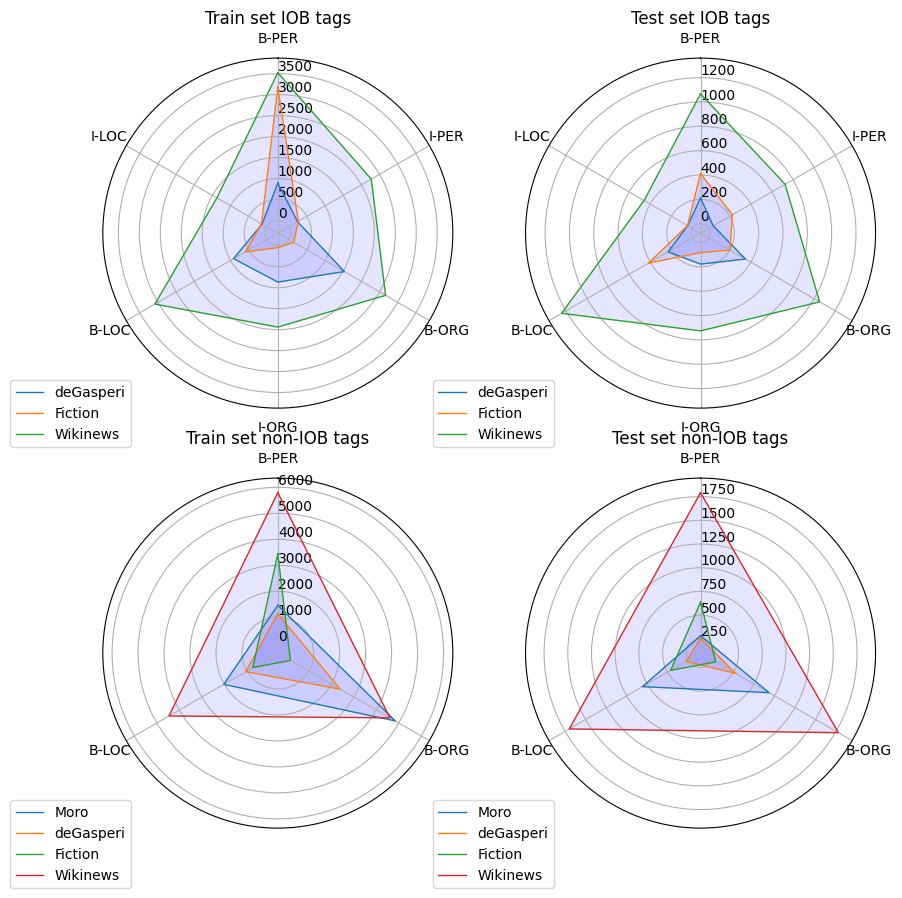

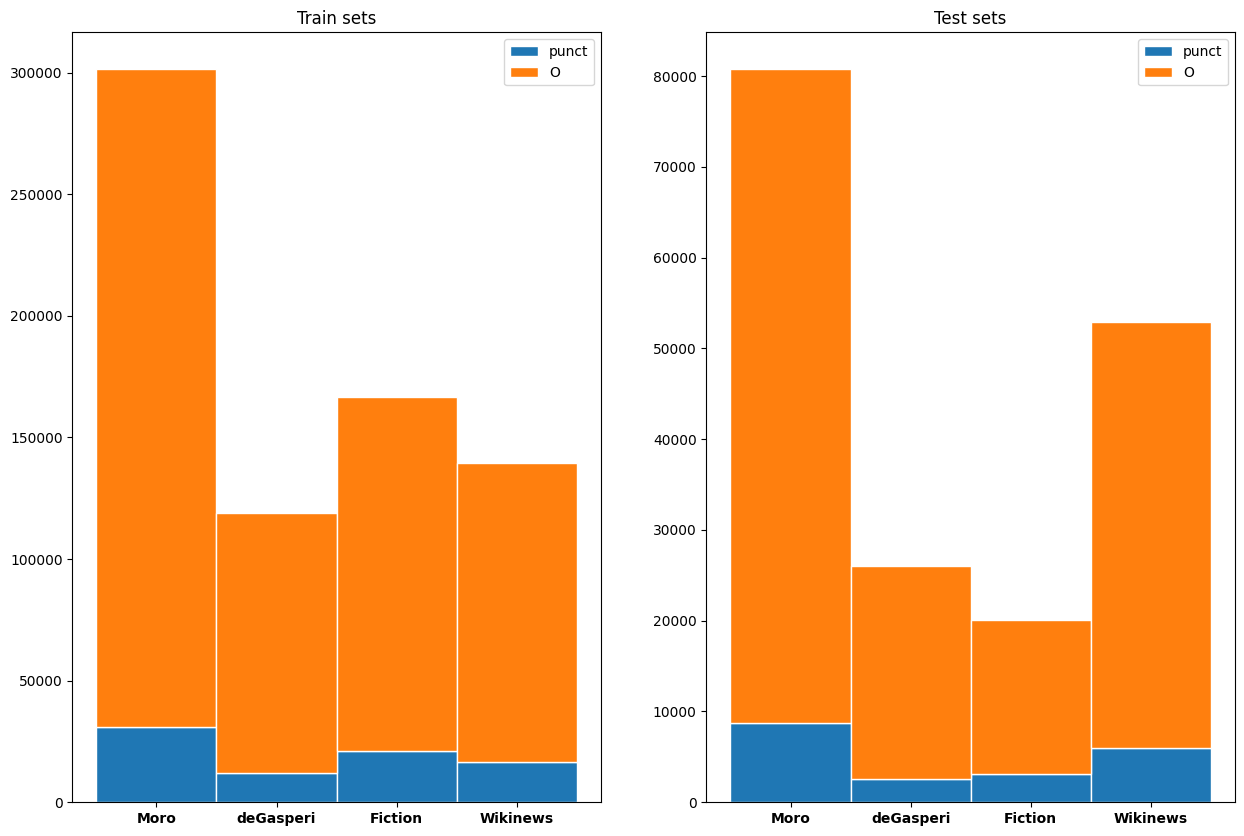

In [17]:
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from matplotlib import rc



BIO_PATH = '../datasets/BIO_tag_NER_notation/'
nonBIO_PATH = '../datasets/Inside_outside_NER_notation/'


SPIDER_ROW_N = 2
SPIDER_COL_N = 2
BAR_ROW_N = 1 
BAR_COL_N = 2

def to_lowerCase(df):
    return pd.DataFrame({'Token': df['Token'].str.lower(), 'Entity': df['Entity']})

def add_column_names(df):
    return  df.rename(columns={0: 'Token', 1: 'Entity'})

def spider_plot(df, group, title, subplot_idx):
    plt.rcParams["figure.figsize"] = (10,10)
    categories=list(df)[:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(SPIDER_ROW_N, SPIDER_COL_N, subplot_idx, polar=True)
    
    # first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)
    
    # Draw ylabels
    #ax.set_yscale('log')
    ax.set_rlabel_position(0)
    min = df.min().min()
    max = df.max().max()
    plt.ylim(min -(max-min)/10, max + (max-min)/10)
 
    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable
    
    for i in range(len(group)):
        values=df.loc[i].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=group[i])
        ax.fill(angles, values, 'b', alpha=0.1)

    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(title)

    # Show the graph
    #plt.show()

############################################################### reading datasets ###############################################################

ds = {'ds_mr'           : pd.read_csv(nonBIO_PATH + 'moro_train.tsv', sep='\t', header=None),
      'ds_mr_test'      : pd.read_csv(nonBIO_PATH + 'moro_test.tsv', sep='\t', header=None),
      
      'ds_dg_IOB'       : pd.read_csv(BIO_PATH + 'degasperi_train_BIO.tsv', sep='\t', header=None),
      'ds_fc_IOB'       : pd.read_csv(BIO_PATH + 'fiction_train_BIO.tsv', sep='\t', header=None),
      'ds_wn_IOB'       : pd.read_csv(BIO_PATH + 'wikinews_train_BIO.tsv', sep='\t', header=None),
      'ds_dg_IOB_test'  : pd.read_csv(BIO_PATH + 'degasperi_test_BIO.tsv', sep='\t', header=None),
      'ds_fc_IOB_test'  : pd.read_csv(BIO_PATH + 'fiction_test_BIO.tsv', sep='\t', header=None),
      'ds_wn_IOB_test'  : pd.read_csv(BIO_PATH + 'wikinews_test_BIO.tsv', sep='\t', header=None)
}

############################################################### calculating stats ###############################################################
stats = {}

for i in ds.keys():     
    ds[i] = add_column_names(ds[i])
    ds[i] = to_lowerCase(ds[i])

    stats[i] = {
        'doc_len' : ds[i]['Token'].count(),
        'voc_size' : ds[i]['Token'].nunique(),
        'n_punct': sum(1 for k in ds[i]['Token'] if all(char in string.punctuation for char in k))
    }

    if('IOB' in str(i)):
        
        stats[i]['n_I-PER'] = sum(1 for k in ds[i]['Entity'] if k == 'I-PER') 
        stats[i]['n_I-ORG'] = sum(1 for k in ds[i]['Entity'] if k == 'I-ORG')
        stats[i]['n_I-LOC'] = sum(1 for k in ds[i]['Entity'] if k == 'I-LOC')

        stats[i]['n_B-PER'] = sum(1 for k in ds[i]['Entity'] if k == 'B-PER') 
        stats[i]['n_B-ORG'] = sum(1 for k in ds[i]['Entity'] if k == 'B-ORG')
        stats[i]['n_B-LOC'] = sum(1 for k in ds[i]['Entity'] if k == 'B-LOC')

        stats[i]['n_PER'] = stats[i]['n_I-PER'] + stats[i]['n_B-PER']
        stats[i]['n_ORG'] = stats[i]['n_I-ORG'] + stats[i]['n_B-ORG']
        stats[i]['n_LOC'] = stats[i]['n_I-LOC'] + stats[i]['n_B-LOC']
        
    else:
        stats[i]['n_PER'] = sum(1 for k in ds[i]['Entity'] if k == 'PER') 
        stats[i]['n_ORG'] = sum(1 for k in ds[i]['Entity'] if k == 'ORG')
        stats[i]['n_LOC'] = sum(1 for k in ds[i]['Entity'] if k == 'LOC')

    stats[i]['n_O'] = sum(1 for k in ds[i]['Entity'] if k == 'O')
        

avg_doc_len = sum(stats[i]['doc_len'] for i in stats.keys()) / len(stats.keys())
avg_voc_size = sum(stats[i]['voc_size'] for i in stats.keys()) / len(stats.keys())

############################################################### preparing data for plotting ###############################################################
 
# Values of each group
iper = [stats[i]['n_I-PER'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
iorg = [stats[i]['n_I-ORG'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
iloc = [stats[i]['n_I-LOC'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]

bper = [stats[i]['n_B-PER'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
borg = [stats[i]['n_B-ORG'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
bloc = [stats[i]['n_B-LOC'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]

iob_punct = [stats[i]['n_punct'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
iob_o = [stats[i]['n_O'] for i in stats.keys() if 'IOB' in str(i) and 'test' not in str(i)]
iob_o = [iob_o[i] - iob_punct[i] for i in range(len(iob_o))]

iper_test = [stats[i]['n_I-PER'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
iorg_test = [stats[i]['n_I-ORG'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
iloc_test = [stats[i]['n_I-LOC'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]

bper_test = [stats[i]['n_B-PER'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
borg_test = [stats[i]['n_B-ORG'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
bloc_test = [stats[i]['n_B-LOC'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]

iob_punct_test = [stats[i]['n_punct'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
iob_o_test = [stats[i]['n_O'] for i in stats.keys() if 'IOB' in str(i) and 'test' in str(i)]
iob_o_test = [iob_o_test[i] - iob_punct_test[i] for i in range(len(iob_o_test))]

iob_voc_size = [stats[i]['voc_size'] for i in stats.keys() if 'IOB' in str(i)]

per = [stats[i]['n_PER'] for i in stats.keys() if 'test' not in str(i)]
org = [stats[i]['n_ORG'] for i in stats.keys() if 'test' not in str(i)]
loc = [stats[i]['n_LOC'] for i in stats.keys() if 'test' not in str(i)]

per_test = [stats[i]['n_PER'] for i in stats.keys() if 'test' in str(i)]
org_test = [stats[i]['n_ORG'] for i in stats.keys() if 'test' in str(i)]
loc_test = [stats[i]['n_LOC'] for i in stats.keys() if 'test' in str(i)]

voc_size = [stats[i]['voc_size'] for i in stats.keys() if 'test' not in str(i)]
voc_size_test = [stats[i]['voc_size'] for i in stats.keys() if 'test' in str(i)]

doc_len = [stats[i]['doc_len'] for i in stats.keys() if 'test' not in str(i)]
doc_len_test = [stats[i]['doc_len'] for i in stats.keys() if 'test' in str(i)]

n_punct = [stats[i]['n_punct'] for i in stats.keys() if 'test' not in str(i)]
n_punct_test = [stats[i]['n_punct'] for i in stats.keys() if 'test' in str(i)]

o = [stats[i]['n_O'] for i in stats.keys() if 'test' not in str(i)]
punct = [stats[i]['n_punct'] for i in stats.keys() if 'test' not in str(i)]


o_test = [stats[i]['n_O'] for i in stats.keys() if 'test' in str(i)]
punct_test = [stats[i]['n_punct'] for i in stats.keys() if 'test' in str(i)]

############################################################### spider plots ###############################################################

spider_plot( pd.DataFrame({
    'B-PER': bper,
    'I-PER': iper,
    'B-ORG': borg,
    'I-ORG': iorg,
    'B-LOC': bloc,
    'I-LOC': iloc }),
    ['deGasperi', 'Fiction', 'Wikinews'],
    'Train set IOB tags',
    1)

spider_plot( pd.DataFrame({
    'B-PER': bper_test,
    'I-PER': iper_test,
    'B-ORG': borg_test,
    'I-ORG': iorg_test,
    'B-LOC': bloc_test,
    'I-LOC': iloc_test }),
    ['deGasperi', 'Fiction', 'Wikinews'],
    'Test set IOB tags',
    2)

spider_plot( pd.DataFrame({
    'B-PER': per,
    'B-ORG': org,
    'B-LOC': loc}),
    ['Moro', 'deGasperi', 'Fiction', 'Wikinews'],
    'Train set non-IOB tags',
    3)

spider_plot( pd.DataFrame({
    'B-PER': per_test,
    'B-ORG': org_test,
    'B-LOC': loc_test}),
    ['Moro', 'deGasperi', 'Fiction', 'Wikinews'],
    'Test set non-IOB tags',
    4)

#spider_plot( pd.DataFrame({
#    'doc_len': doc_len,
#    'voc_size': voc_size,
#    'n_punct': n_punct,}),
#    ['Moro', 'deGasperi', 'Fiction', 'Wikinews'],
#    'Train set document statistics',
#    5)
#
#spider_plot( pd.DataFrame({
#    'doc_len': doc_len_test,
#    'voc_size': voc_size_test,
#    'n_punct': n_punct_test,}),
#    ['Moro', 'deGasperi', 'Fiction', 'Wikinews'],
#    'Test set document statistics',
#    6)

plt.show()


def stacked_bar_plot(col_names, data, labels_name, title, subplot_idx):
    plt.rcParams["figure.figsize"] = (15,10)
    # Names of group and bar width
    barWidth = 1
    bars = np.zeros(len(col_names))
    n_col = np.arange(len(col_names))
    plt.subplot(BAR_ROW_N, BAR_COL_N, subplot_idx)


    for i in range(len(data)):
        plt.bar(n_col, data[i], bottom=bars, edgecolor='white', width=barWidth, label=labels_name[i])
        bars = np.add(bars, data[i]).tolist()

    bars = np.add(bper, iper).tolist()
    
    # Custom X axis
    plt.xticks(n_col, col_names, fontweight='bold')
    plt.legend()
    plt.title(title)

    
    # Show graphic
stacked_bar_plot(['Moro', 'deGasperi', 'Fiction', 'Wikinews'],
                 [punct, [o[i]-punct[i] for i in range(len(o))]],
                 ['punct', 'O'],
                 'Train sets',
                 1)

stacked_bar_plot(['Moro', 'deGasperi', 'Fiction', 'Wikinews'],
                 [punct_test, [o_test[i]-punct_test[i] for i in range(len(o_test))]],
                 ['punct', 'O'],
                 'Test sets',
                 2)

plt.show()

In [6]:
import pandas as pd
import os

#BIO_PATH = 'BIO_tag_NER_notation'
#nonBIO_PATH = 'Inside_outside_NER_notation'

#function to check if 2 tsv files are equal
def check_equal(file1, file2):
	df1 = pd.read_csv(file1, sep='\t')
	df2 = pd.read_csv(file2, sep='\t')
	#printf the path of the two filr, length of the 2 files, and if they are equal
	print(file1, "\n", 
       	  file2, "\n",
		    "equal: ", df1.equals(df2), "\n\n")


#########################à BIO TAGGER ########################################

oTag = "O"  
types = set()

files = {
	"wikinews_train.tsv"	: BIO_PATH + "automatic/WN_train.tsv",
	"wikinews_test.tsv"		: BIO_PATH + "automatic/WN_dev.tsv",
	"fiction_train.tsv"		: BIO_PATH + "automatic/FIC_train.tsv",
	"fiction_test.tsv"		: BIO_PATH + "automatic/FIC_dev.tsv",
	"degasperi_train.tsv"	: BIO_PATH + "automatic/ADG_train.tsv",
	"degasperi_test.tsv"	: BIO_PATH + "automatic/ADG_dev.tsv",
	"moro_train.tsv"		: BIO_PATH + "automatic/MR_train.tsv",
	"moro_test.tsv"			: BIO_PATH + "automatic/MR_dev.tsv",
}

count = {}

for file in files:
	with open(os.path.join(nonBIO_PATH, file), "r") as f:
		outFile = files[file]
		count[outFile] = {"sentences": 0, "tags": {}, "tokens": 0}

		sentences = []
		thisSentence = []

		for line in f:
			line = line.strip()
			if len(line) == 0:
				if len(thisSentence) > 0:
					sentences.append(thisSentence)
					thisSentence = []
				continue
			parts = line.split("\t")
			thisSentence.append(parts)
			count[outFile]["tokens"] += 1

		if len(thisSentence) > 0:
			sentences.append(thisSentence)

		count[outFile]["sentences"] = len(sentences)

		for sentence in sentences:
			previousNer = oTag
			for token in sentence:
				ner = token[1]
				newNer = ner
				if ner != oTag:
					if previousNer != ner:
						if ner not in count[outFile]["tags"]:
							count[outFile]["tags"][ner] = 0
						newNer = "B-" + ner
						count[outFile]["tags"][ner] += 1
						types.add(ner)
					else:
						newNer = "I-" + ner
				token[1] = newNer
				previousNer = ner

		with open(outFile, "w") as fw:
			for sentence in sentences:
				for token in sentence:
					fw.write(token[0])
					fw.write("\t")
					fw.write(token[1])
					fw.write("\n")
				fw.write("\n")

#########################à CHECK ########################################
comp = [
	[BIO_PATH + "automatic/WN_train.tsv", 	'./' + BIO_PATH + '/wikinews_train_BIO.tsv'],
	[BIO_PATH + "automatic/WN_dev.tsv", 	'./' + BIO_PATH + '/wikinews_test_BIO.tsv'],
	[BIO_PATH + "automatic/FIC_train.tsv", 	'./' + BIO_PATH + '/fiction_train_BIO.tsv'],
	[BIO_PATH + "automatic/FIC_dev.tsv", 	'./' + BIO_PATH + '/fiction_test_BIO.tsv'],
	[BIO_PATH + "automatic/ADG_train.tsv", 	'./' + BIO_PATH + '/degasperi_train_BIO.tsv'],
	[BIO_PATH + "automatic/ADG_dev.tsv", 	'./' + BIO_PATH + '/degasperi_test_BIO.tsv'],
	[BIO_PATH + "automatic/MR_train.tsv", 	'./' + BIO_PATH + '/moro_train_BIO.tsv'],
	[BIO_PATH + "automatic/MR_dev.tsv", 	'./' + BIO_PATH + '/moro_test_BIO.tsv'],
]

for i in comp:
	check_equal(i[0], i[1])


../datasets/BIO_tag_NER_notation/automatic/WN_train.tsv 
 ./../datasets/BIO_tag_NER_notation//wikinews_train_BIO.tsv 
 equal:  True 


../datasets/BIO_tag_NER_notation/automatic/WN_dev.tsv 
 ./../datasets/BIO_tag_NER_notation//wikinews_test_BIO.tsv 
 equal:  True 


../datasets/BIO_tag_NER_notation/automatic/FIC_train.tsv 
 ./../datasets/BIO_tag_NER_notation//fiction_train_BIO.tsv 
 equal:  True 


../datasets/BIO_tag_NER_notation/automatic/FIC_dev.tsv 
 ./../datasets/BIO_tag_NER_notation//fiction_test_BIO.tsv 
 equal:  True 


../datasets/BIO_tag_NER_notation/automatic/ADG_train.tsv 
 ./../datasets/BIO_tag_NER_notation//degasperi_train_BIO.tsv 
 equal:  True 


../datasets/BIO_tag_NER_notation/automatic/ADG_dev.tsv 
 ./../datasets/BIO_tag_NER_notation//degasperi_test_BIO.tsv 
 equal:  True 


../datasets/BIO_tag_NER_notation/automatic/MR_train.tsv 
 ./../datasets/BIO_tag_NER_notation//moro_train_BIO.tsv 
 equal:  True 


../datasets/BIO_tag_NER_notation/automatic/MR_dev.tsv 
 ./../dat

# Extra

In [ ]:
# Elia valuta se può essere utile, altrimenti eliminiamo
def compute_statistics(dataset_name, dataset, statistics_df):
  '''
  Computes the statistics of the dataset and adds it into an aggregated structure

  Parameters
  ----------
  dataset_name: str
  dataset: DataFrame
  statistics_df: DataFrame

  Returns
  -------
  statistics_df: DataFrame
  '''
  if statistics_df is None:
    columns = ['Dataset', 'Number of tokens', 'Number of unique tokens', 'Entity tag types']
    statistics_df = pd.DataFrame([[dataset_name, len(dataset), len(dataset['Token'].unique()), sorted(dataset['Tag'].unique())]], columns=columns)
  else:
    columns = ['Dataset', 'Number of tokens', 'Number of unique tokens', 'Entity tag types']
    statistics_df = pd.concat([statistics_df, pd.DataFrame([[dataset_name, len(dataset), len(dataset['Token'].unique()), sorted(dataset['Tag'].unique())]], columns=columns)])
  return statistics_df



  # Rimuovi l'hardcoding dei nomi delle colonne

In [ ]:
# Elia valuta se può essere utile, altrimenti eliminiamo
datasets_df = []
dataset_stats_df = None

for dataset_name in dataset_names:
  dataset_df = pd.read_csv(dataset_name, sep='\t', names=['Token', 'Tag'])
  datasets_df.append(dataset_df)
  dataset_stats_df = compute_statistics(dataset_name, dataset_df, dataset_stats_df)

dataset_stats_df.style.hide(axis='index')

In [2]:
!pwd

/home/elia/polimi/2sem/NLP/project/KIND_project/notebook
